# Tutorial

In this notebook we will leverage Google Colab to introduce concepts that will be useful in subsequent installements of this tutorial. In the Colab section, no installation will be required. After that, there will be an installation section which should contain all necessary instructions to run the same notebook locally on your own device.

# Google Colab

This tutorial will introduce you to running code on Google Colab whose documentation says:
> Colaboratory, or “Colab” for short, is a product from Google Research. Colab allows anybody to write and execute arbitrary python code through the browser, and is especially well suited to machine learning, data analysis and education. More technically, Colab is a hosted Jupyter notebook service that requires no setup to use, while providing free access to computing resources including GPUs.

## Why python? Isn't it slow?

Particularly [as it compares to C][benchmark-python-c], the execution of python code is generally slow. This is for many reasons, including that it is not statically typed by default, and its interpreter will not perform optimizations for you. Naively, it is easy to make mistakes that can make code too slow, such as writing excessively nested for loops (if you go past 3 then there might be a better approach). That being said, typically [most people don't care about program performance most of the time][slow-dont-care].
<details>
<summary>
<br />
Advantages of python include its large community and many very useful packages. This makes the time spent coding for python much faster, and many people choose python for precisely this reason. If you run into a problem then you will have many people who have probably run into this problem before. If you want to do something fancy then there is a good chance that you can do it with an appropriate package.
</summary>

<a href="https://xkcd.com/353/"><img src="https://imgs.xkcd.com/comics/python.png" title="I wrote 20 short programs in Python yesterday. It was wonderful. Perl, I'm leaving you."></a>
</details>

[benchmark-python-c]: https://benchmarksgame-team.pages.debian.net/benchmarksgame/fastest/python3-gcc.html
[slow-dont-care]: https://tratt.net/laurie/blog/entries/what_challenges_and_trade_offs_do_optimising_compilers_face.html

<details><summary>

### Aside: Tutorial structure

</summary>

You should be able to read straight through and understand this notebook, but you may decide to skip the **Aside** sections at first. They break up the narrative of this notebook somewhat, but they contain important information about the subsequently used terms. If you skip one and are suddenly presented with unfamiliar terms then you might find the answer in a previous Aside.
</details>

## Scatter plot of real data

Let's modify [the Scatter plot matplotlib example](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html) to use some real data and demonstrate some important principles.

We're going to use the [Asterank Minor Planet Center API](http://www.asterank.com/mpc) to get information on 1000 asteroids to make a sample scatter plot.

<details><summary>

### Aside: Importing Modules

</summary>

It is customary to import all necessary modules for a script, or notebook, at the beginning. A primary goal of python is to produce code which is readable since code is much more often read than written. To that end, each python script should contain enough information to determine where an identifier is defined. This is one reason that star imports, that is, an import like `from some_module import *`, are discouraged. Star imports make it harder to see where a variable is defined. By convention, importing modules is often done in one of the first code cells in a notebook.

</details>

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

## Using the `requests` module

The `requests` module gives us a `get` function which makes HTTP GET requests. We will use this to make a request for the first 1000 asteroids in the Minor Planet Center API.

In [2]:
response = requests.get("http://www.asterank.com/api/mpc")

<details><summary>

### Aside: Types in python

</summary>

Here are some example literals in python and their corresponding data types:
- `1729`: `int` for integer
- `"hello"`: `str` for string
- `["hello", 1729]`: `list`. This list contains the following _items_: the string `hello`, and an integer `1729`
- `{"hello": 1729}`: `dict` for dictionary, a mapping type. This one has a _key_, the string `hello`, and a _value_, an integer `1729`.
- `{"hello", 1729}`: `set`

There are some more [general terms][python-glossary] that are useful to know when referring to types in python: sequence types, mapping types and [iterable][python-iterable]. For more information, see the documentation for python's [built-in types][python-stdtypes].

[python-stdtypes]: https://docs.python.org/3/library/stdtypes.html
[python-glossary]: https://docs.python.org/3/glossary.html
[python-iterable]: https://docs.python.org/3/glossary.html#term-iterable

</details>

The `response` variable contains all the information about the response to our request. The response data is encoded in [JSON](https://www.json.org/), a lightweight data-interchange format meant for humans and machines. In JSON, the data is an array of objects, but by using the `.json()` method it gets loaded as a list whose items are dictionaries.
We can use the built-in `len` function to get the length of variables of many types, including this one.

In [3]:
asteroids = response.json()
len(asteroids)

1000

In this case, each item is a dict with the same keys. We will make use of this fact to subsequently save this data in a different format. For now, let's peek at some data from the first few items:

<details><summary>

### Aside: Slices and f-strings

</summary>

Slices in python are ways of selecting a subsequence of a [sequence][python-sequence] object. In this case, we will pick the first five items by using the slice `[:5]`. Slices can be applied to any sequence type, in this case a list. If you are new to python then the [informal introduction to strings][python-informal-strings] will be useful to understand slicing.

A relatively new string formatting feature in python is the [f-string][python-f-string]. This makes it easy to produce strings with the results of expressions inside. They cover many use cases, but the old `str.format()` method and printf-style string formatting are still available. We prefer f-strings and will use them throughout this tutorial.

[python-f-string]: https://docs.python.org/3/tutorial/inputoutput.html#formatted-string-literals
[python-informal-strings]: https://docs.python.org/3/tutorial/introduction.html#strings
[python-sequence]: https://docs.python.org/3/library/stdtypes.html#sequence-types-list-tuple-range

In [4]:
for asteroid in asteroids[:5]:
    print(f"""Asteroid designation: {asteroid["readable_des"]}""")

Asteroid designation: (1) Ceres
Asteroid designation: (2) Pallas
Asteroid designation: (3) Juno
Asteroid designation: (4) Vesta
Asteroid designation: (5) Astraea


## Plotting using matplotlib and pyplot

Now that we have our real data, let's plot it. For a scatter plot you usually need at least two variables. We will use four to demonstrate some benefits of matplotlib. We will take the eccentricities, inclinations, magnitudes and observations to create our plot. One axis will be the eccentricity and another will be the inclination. Will there be an obvious correlation?

<details><summary>

### Aside: List comprehensions

</summary>

The venerable for loop is a main stay of computer programming, but in python it holds extra functionality that is not always required. In many applications what is really desired is to take a list of items and create another list with the items transformed or filtered in some way. Python has a specific pattern for this type of transformation called a list comprehension. List comprehensions have benefits over for loops in that they are expressions, as opposed to statements, which means they are faster in many cases. Consider this article from 2004 on [efficient string concatenation][python-string-concat] which compares the speed of using several solutions. The trade off is that you lose control flow abilities such as `break` and `continue`, but most of the use cases for these can also be included in a list comprehension using its `if` clause. Here is an example of a list comprehension computing all the even squares less than 100:

```python
[ x**2
  for x in range(12)
  if (x**2 % 2) == 0
  if x**2 < 100
]
```

This is an example of a general pattern using list comprehensions:

```python
[
    transform(item)
    for item in items
    if passes_test(item)
]
```

Another benefit of list comprehensions is readability, but that is more difficult to measure objectively.

[python-string-concat]: https://waymoot.org/home/python_string/

</details>

In [5]:
eccentricitys = [asteroid["e"] for asteroid in asteroids]
inclinations = [asteroid["i"] for asteroid in asteroids]
magnitudes = [asteroid["H"] for asteroid in asteroids]
observations = [asteroid["num_obs"] for asteroid in asteroids]

The number of observations will be used to size the dots in our figure. Their raw values are not well-suited to this, so we will scale them.

In [6]:
def scale_observation(obs):
    return 30*(1+math.exp(obs/(max(observations) - min(observations))))

observations_scaled = [scale_observation(observation) for observation in observations]

Now we are ready to plot the data, we will be using the magnitudes to determine the color of the dots.

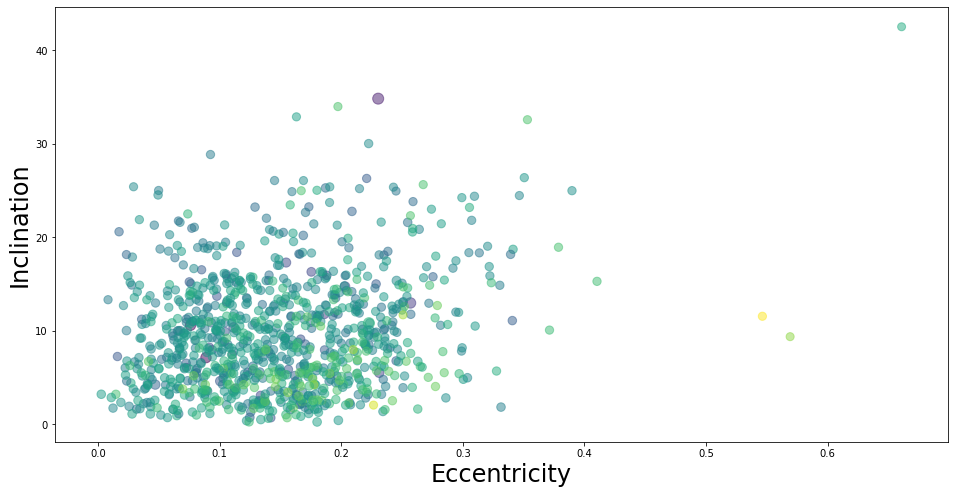

In [7]:
plt.subplots(figsize=(16,8))
plt.scatter(
    eccentricitys,
    inclinations,
    s=observations_scaled,
    c=magnitudes,
    alpha=0.5,
)
plt.xlabel("Eccentricity", fontdict=dict(size=24))
plt.ylabel("Inclination", fontdict=dict(size=24))
plt.show()

<details><summary>

### Aside: pandas and DataFrames

</summary>
    
The `pandas` module provides a special python class called `DataFrame` that provides nice ways to view and crunch tabular data. See [this datacamp tutorial][python-dataframes] for a gentle introduction to [DataFrames in Python][python-dataframes]. In this tutorial we will use `DataFrame`s for the common use case of extracting, transforming and loading data (ETL). It is also conventional to abbreviate `pandas` as `pd` which we enabled by our import statement above and will continue to follow.

[python-dataframes]: https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python

</details>

That does not look a strong correlation to me, but we can answer this question more precisely by computing the correlation coefficients between each variable. The `pandas` module can do this for us once we make a `DataFrame`. We could make a `DataFrame` from the object directly, like so:

In [8]:
df = pd.DataFrame(asteroids)
df.tail()

,rms,epoch,readable_des,H,num_obs,ref,G,last_obs,comp,M,...,a,om,pert_p,d,i,des,flags,num_opp,w,pert_c
995,0.46,K194R,(996) Hilaritas,10.88,2558,MPO458836,0.15,20181025,MPCLINUX,275.62612,...,3.089633,347.39976,38h,0.181486,0.65890,00996,0000,44,146.96786,M-v
996,0.45,K194R,(997) Priska,12.50,1573,MPO452172,0.15,20180713,MPCLINUX,342.83263,...,2.669415,247.09868,38h,0.225985,10.50876,00997,0000,27,51.20357,M-v
997,0.43,K194R,(998) Bodea,11.50,1416,MPO458836,0.15,20181020,MPCLINUX,89.25930,...,3.118658,301.17925,38h,0.178959,15.50515,00998,0000,27,72.13897,M-v
998,0.43,K194R,(999) Zachia,10.80,1938,MPO452172,0.15,20180604,MPCLINUX,225.79276,...,2.610981,214.97085,38h,0.233614,9.76088,00999,0000,42,127.87392,M-v
999,0.40,K194R,(1000) Piazzia,10.50,1949,MPO452172,0.15,20180612,MPCLINUX,347.90772,...,3.171009,323.73562,38h,0.174545,20.57429,01000,0000,33,280.89766,M-v


But let's take the scenic route to show off some more patterns in python and features of pandas.

Each item in the `asteroids` list is a dictionary with data about a particular asteroid. The keys in each dict are the same, so we could also store this data in a flat file. Before we do that, we will pare it down to just the data we care about.

Here we are going to make a string containing the data we want where each record will be separated by newlines and each value unit within the record will be separated by a tab which we will save into a tab separated values (TSV) file. In this case we'll just store the values for each asteroid name and its values for eccentricity, inclination, magnitude and the number of observations.

In [9]:
headers = ["\t".join(["Name", "Eccentricity", "Inclination", "Magnitude", "Number of observations"])]

rows = ["\t".join([
    asteroid["readable_des"],
    str(asteroid["e"]),
    str(asteroid["i"]),
    str(asteroid["H"]),
    str(asteroid["num_obs"]),
]) for asteroid in asteroids]

table = "\n".join(headers + rows)

print(table[:216])

Name	Eccentricity	Inclination	Magnitude	Number of observations
(1) Ceres	0.0760091	10.59407	3.34	6725
(2) Pallas	0.2303368	34.83623	4.13	7961
(3) Juno	0.2569423	12.98892	5.33	6948
(4) Vesta	0.0887214	7.14177	3.2	6920


Now that we have a string with this data, let's write it to a file.

<details><summary>

### Aside: context managers and file operations

</summary>

Working with files in python is not significantly different than other languages, but hopefully you will find it somewhat easier. The [`open`][python-open] built-in function will create a file object, (sometimes referred to in other languages as a file descriptor) for a file and open the file in the mode you specify. When opening files in this way, it is important to call the file object's `close` method when you are done with them to avoid data corruption, however python does have a way of managing this context for you.

Context managers in python can be used in these situations where objects must be cleaned up once accessed. This usually shows up in code as simply using the `with` keyword as below. This is the preferred way to access files in python and you can read more in the [Reading and Writing Files][python-tutorial-rw-files] section of the python tutorial.

[python-open]: https://docs.python.org/3/library/functions.html#open
[python-tutorial-rw-files]: https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files

</details>

In [10]:
with open("astvars.txt", "w") as asteroid_tsv:
    asteroid_tsv.write(table)

Use `pandas.read_csv` to load the flat file as a `DataFrame`.

In [11]:
df = pd.read_csv("astvars.txt", sep="\t")
df.head()

,Name,Eccentricity,Inclination,Magnitude,Number of observations
0,(1) Ceres,0.076009,10.59407,3.34,6725
1,(2) Pallas,0.230337,34.83623,4.13,7961
2,(3) Juno,0.256942,12.98892,5.33,6948
3,(4) Vesta,0.088721,7.14177,3.20,6920
4,(5) Astraea,0.191095,5.36699,6.85,2551


Now that we have a `DataFrame` we can use its methods to compute many different statistics and views of the original data. In our case, let's compute the correlation coefficients with `pandas.DataFrame.corr` and provide some visual cues using `.style.background_gradient()`:

In [12]:
df.corr().style.background_gradient()

,Eccentricity,Inclination,Magnitude,Number of observations
Eccentricity,1,0.218759,0.131198,-0.109189
Inclination,0.218759,1,-0.174279,-0.232689
Magnitude,0.131198,-0.174279,1,-0.320868
Number of observations,-0.109189,-0.232689,-0.320868,1


Not much of a correlation, so it seems the numbers back up the plot. You can also guess a bit of astronomy here. Number of observations and magnitude are negatively correlated, so you might expect that [greater magnitude values correspond to dimmer objects][wiki-magnitude] (which is true). Neat!

Now let's do it locally!

[wiki-magnitude]: https://en.wikipedia.org/wiki/Magnitude_(astronomy)

# Local installation

## `python`

Right now you may be thinking, "Don't I already have python installed?". Probably! However it is best to avoid using the system python for a given operating system. This is primarily because operating systems often have critical tools that rely on the system installation being *just so* and it is better to avoid tampering with it in a way that will cause problems. Also it's likely that the version that ships with your system is not python 3 or a number of other caveats. If you want to use your system python to continue, do so at your own risk. This tutorial will install a fresh python and proceed from there.

<details><summary>

### Aside: system and language level dependencies

</summary>

Note that some python packages are really wrappers of lower level tools. For instance the `psycopg2` package provides a wrapper for the Postgres database engine. In order to use it you will need a Postgres database running somewhere. It is useful to distinguish these kinds of dependencies, that is, the database engine and the python package. This tutorial will refer to Postgres and similar dependencies as **system level dependencies** and python packages as **language level dependencies**. Installing system level dependencies will differ based on the operating system in use, but this tutorial will endeavor to make sure that, once they are in place, the instructions for the language level dependencies will be the same on each platform. In our case, python is a system level dependency, so we will need to install it.

</details>

## Installing `python3.9`

Find your operating system below and follow the instructions to install a recent version of python 3. After completing these steps you should be able to open a shell session and run `python3.9 --version` to see the version of python that you installed. If this is not working, try starting again from scratch. Failing that, seek assistance. If your operating system is not listed then this tutorial assumes you either already know how to do this or how to find out how to do it. Good luck!

<details><summary>

### Aside: The `PATH` variable

</summary>

In [POSIX][wiki-posix] shells, the `PATH` variable dictates where the shell looks for commands. Following the instructions below should not present you with any `PATH` related issues. Some of the installation methods will modify your shell profiles to configure your `PATH` to run the new python, and in this case you may need to create a new shell session for `python3.9 --version` to work.

[wiki-posix]: https://en.wikipedia.org/wiki/POSIX

</details>

### Mac OS

Download a [python3.9 for Mac OS][python-macos] installer from python.org. Once `python3.9` is installed, open a shell prompt and run `python3.9 --version` to confirm that it is installed correctly.

[python-macos]: https://www.python.org/downloads/macos/

### Ubuntu

In the latest release you should be able to run the following command with no issues (although you may need to run them with `sudo`):

```sh
apt-get update
apt-get --yes install python3.9 python3.9-dev python3-venv
```

If you are on an older release and see an error like `E: Unable to locate package python3.9` then you may need the assistance of the [deadsnakes PPA][deadsnakes-ppa] project.

[deadsnakes-ppa]: https://launchpad.net/~deadsnakes/+archive/ubuntu/ppa

### Windows

While it is by no means impossible to install python natively within windows and run everything these tutorials will cover locally, there are so many differences in this case and the others that we will punt and suggest that you [enable WSL2 and install Ubuntu][wsl2-ubuntu] and then follow the above Ubuntu instructions.

[wsl2-ubuntu]: https://docs.microsoft.com/en-us/windows/wsl/install#install

## WARNING: Beyond this point, root will not be required.

If you are used to running a command, watching it fail and then running it again with `sudo` in front of it then you should start breaking that habit now. Running `sudo` in improper situations can result in harder to fix problems.

## Python packages and `pip`

<details>
<summary>
<br />

What we did in colab requires python modules that are not in the python standard library.  Python packages provide modules that satisfy these sorts of language level dependencies. Installing packages is done with `pip`, which is another command that must be installed at the system level. If you followed the above instructions then you should already have `pip`. Even so, we will call `pip` with the invocation `python3.9 -m pip` as this avoids many common environment related problems.

</summary>

<a href="https://xkcd.com/1987/"><img src="https://imgs.xkcd.com/comics/python_environment.png" title="The Python environmental protection agency wants to seal it in a cement chamber, with pictorial messages to future civilizations warning them about the danger of using sudo to install random Python packages."></a>
</details>

<details><summary>

### Aside: How are Anaconda and `conda` different from the steps in this tutorial?

</summary>

An important point to know is that Anaconda manages both system level and language level dependencies. Anaconda manages any compilation and dependency gathering steps for you, where the approach outlined in this tutorial is a more manual one. This trade-off has benefits, particularly when developing your own python packages.
 
You may have used Anaconda before, and you may already have it installed with a version of python 3. If so, great! You probably do not need to install a new version of python. Instead of making a new virtual environment, you may prefer to make a new conda environment. However, the instructions in this tutorial should not interfere with any Anaconda installations and these steps are the only supported starting point for this tutorial series. If you know what you are doing then have at it.
</details>

## Virtual Environments

Python virtual environments are partitions which collecs versions of packages and keeps them separated from the packages of other virtual environments. This can help in situations where packages are mutually incompatible (such as `PIL` and `pillow`), but it is more often used as an aid for project organization. It reduces the likelihood that one project you are working on will break another project. It also helps explicitly identify the dependencies needed for a specific project by using `pip freeze`. You can make a virtual environment using the `venv` module:

```sh
python3.9 -m venv .venv-dir
```

In a POSIX compliant shell you can activate a virtual environment by

```sh
source .venv-dir/bin/activate
```

to deactivate you can run `deactivate`.


## Install language dependencies

In our tutorial notebook we used `pyplot` (provided by `matplotlib`), `pandas` and the `requests` module. We will use `pip` to install the packages that will provide these dependencies into our virtual environment. We will use `jupyter` to run our notebook server.

```sh
python -m pip install jupyter matplotlib pandas requests
```

You may be surprised to learn that the `matplotlib`, `pandas` and `requests` packages supply the `matplotlib`, `pandas` and `requests` modules, respectively. More seriously, package names and module names are not always the same, so you may need to search [pypi][pypi] for the package supplying a given module.

[pypi]: https://pypi.org/

## Run the colab notebook locally

Download the colab notebook by clicking `File > Download > Download .ipynb` and saving the notebook to your local device. Open a shell, activate your virtual environment and change directory to where you saved your notebook. Finally, the notebook server may be run with the following command:

`jupyter notebook --ip 0.0.0.0 --no-browser --port 5000`

This `jupyter notebook` command begins the notebook server responding on port `5000`. The `--no-browser` flag gives us the pleasure of typing the URL ([`http://localhost:5000`](http://localhost:5000)) in our browser ourselves. The `--ip 0.0.0.0` configures the server to respond to requests from your network which solves some problems caused by omitting it.

You should see the tutorial notebook in the file list. Click it and in the notebook click `Kernel > Restart & Run All`. This should run the notebook with no errors, and if that is the case then this tutorial is done!

# Installation Recap

Here are all the installation steps from this tutorial in order:

01. Install `python3.9` for your platform.
02. Run `python3.9 --version`.
03. Make a virtual environment: `python3.9 -m venv .venv-dir`
04. Activate the virtual environment: `source .venv-dir/bin/activate`
05. Install the python package dependencies: `python -m pip install jupyter matplotlib pandas requests`
06. Download this tutorial locally from Google Colab: Click `File > Download > Download .ipynb`.
07. Start the Jupyter server: `jupyter notebook --ip 0.0.0.0 --no-browser --port 5000`
08. Open the notebook server in your browser: [`http://localhost:5000`](http://localhost:5000)
09. Open the tutorial and click `Kernel > Restart & Run All`
10. Enjoy the results! If everything has gone right then the code below should make a scatterplot for the first 5000 asteroids in the data.

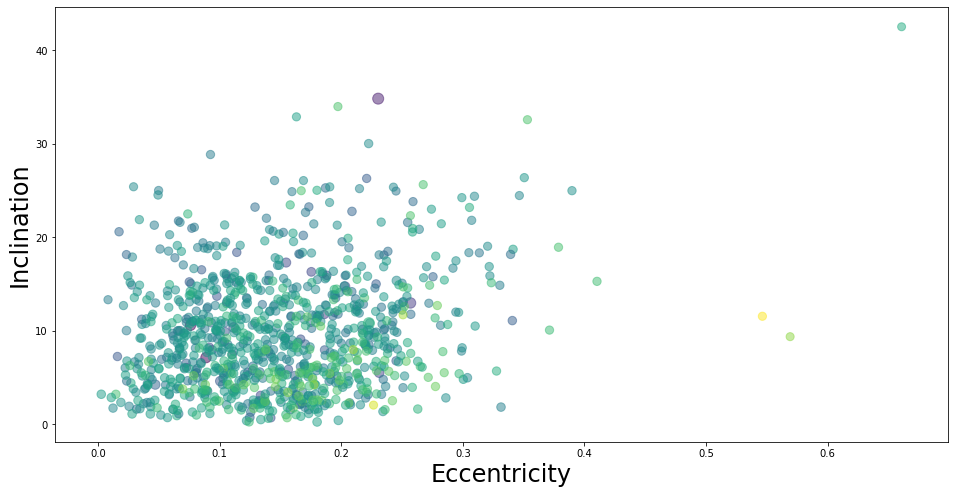

,rms,H,num_obs,G,M,e,a,om,d,i,num_opp,w
rms,1,-0.120182,0.0628439,0.00183938,-0.0185077,0.0511205,0.0229983,0.0280413,-0.00904193,0.0324353,0.155106,0.00303552
H,-0.120182,1,-0.506353,-0.105517,-0.0172814,0.238573,-0.504183,0.0315468,0.537648,-0.192996,-0.833067,-0.0452041
num_obs,0.0628439,-0.506353,1,0.18413,-0.0132223,-0.202691,0.0395991,-0.0838173,-0.133945,-0.268049,0.618347,0.0791085
G,0.00183938,-0.105517,0.18413,1,-0.00872963,-0.0111405,-0.0205521,0.00525023,0.0200971,0.00502395,0.146027,0.00924427
M,-0.0185077,-0.0172814,-0.0132223,-0.00872963,1,0.00300907,0.0267068,-0.0176257,-0.0043171,0.00596568,0.00713886,0.0254865
e,0.0511205,0.238573,-0.202691,-0.0111405,0.00300907,1,-0.197768,0.0161281,0.277524,0.1872,-0.117377,-0.0106631
a,0.0229983,-0.504183,0.0395991,-0.0205521,0.0267068,-0.197768,1,-0.0322984,-0.806079,0.0938122,0.205276,0.0230061
om,0.0280413,0.0315468,-0.0838173,0.00525023,-0.0176257,0.0161281,-0.0322984,1,0.0425242,0.0239615,-0.0305498,-0.140198
d,-0.00904193,0.537648,-0.133945,0.0200971,-0.0043171,0.277524,-0.806079,0.0425242,1,0.00923131,-0.240392,-0.00860322
i,0.0324353,-0.192996,-0.268049,0.00502395,0.00596568,0.1872,0.0938122,0.0239615,0.00923131,1,-0.0546154,0.0220511


In [13]:
response5k = requests.get("https://www.asterank.com/api/mpc?limit=5000")
asteroids5k = response5k.json()
eccentricitys5k = [asteroid["e"] for asteroid in asteroids5k]
inclinations5k = [asteroid["i"] for asteroid in asteroids5k]
magnitudes5k = [asteroid["H"] for asteroid in asteroids5k]
observations5k = [asteroid["num_obs"] for asteroid in asteroids5k]
def scale_observation5k(obs):
    return 30*(1+math.exp(obs/(max(observations5k) - min(observations5k))))
observations_scaled5k = [scale_observation5k(observation) for observation in observations5k]
plt.subplots(figsize=(16,8))
plt.scatter(
    eccentricitys,
    inclinations,
    s=observations_scaled,
    c=magnitudes,
    alpha=0.5,
)
plt.xlabel("Eccentricity", fontdict=dict(size=24))
plt.ylabel("Inclination", fontdict=dict(size=24))
plt.show()
pd.DataFrame(asteroids5k).select_dtypes(include='number').corr().style.background_gradient()

***

## References

Here are some more links that I found useful during the making of this tutorial.

- [Export Format for Minor-Planet Orbits][MPOrbit-format]
- [Code in Asterank MPC API that loads the minor-planet orbits format][asterank-mpc-api-load]
- [Ryugu][asterank-ryugu]
- [Matplotlib `fontdict` docs][matplotlib-fontdict]
- [Matplotlib scatter plot tutorial][matplotlib-scatter-symbol]
- [Matplotlib method `matplotlib.pyplot.scatter` docs][matplotlib.pyplot.scatter]
- [MongoDB `find` docs][mongo-find]
- [Windows VM for testing][mswinvm]
- [Pandas method `pandas.Series.corr` docs][pandas.Series.corr]
- [the POSIX standard][POSIX.1-2017]
- [list of free science and math APIs][public-apis-science-math]
- [Python Beginners' Guide: Download][python-guide-download]

[asterank-mpc-api-load]: https://github.com/typpo/asterank/blob/master/data/pipeline/run/50_mpc/mpcread.py#L29
[asterank-ryugu]: https://www.asterank.com/api/mpc?query={%22readable_des%22:%20{%22$regex%22:%20%22Ryugu%22}}
[matplotlib-scatter-symbol]: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_symbol.html
[matplotlib-fontdict]: https://matplotlib.org/stable/gallery/text_labels_and_annotations/text_fontdict.html
[matplotlib.pyplot.scatter]: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
[mongo-find]: https://docs.mongodb.com/manual/reference/method/db.collection.find/
[MPOrbit-format]: https://minorplanetcenter.net/iau/info/MPOrbitFormat.html
[mswinvm]: https://developer.microsoft.com/en-us/windows/downloads/virtual-machines/
[pandas.Series.corr]: https://pandas.pydata.org/docs/reference/api/pandas.Series.corr.html
[POSIX.1-2017]: https://pubs.opengroup.org/onlinepubs/9699919799/
[public-apis-science-math]: https://github.com/public-apis/public-apis#science--math
[python-guide-download]: https://wiki.python.org/moin/BeginnersGuide/Download